In [1]:
import s3fs
import xarray as xr
import xesmf
import numpy as np

In [2]:
# USER DEFINED INPUTS!
# define the name of our S3 bucket
bucket_name = 'eis-dh-hydro/SNOWEX-HACKWEEK'

# define path to store on S3
lis_output_s3_path_time_chunk = f's3://{bucket_name}/2022/ZARR/SURFACEMODEL/LIS_HIST_rechunkedV4.d01.zarr'
lis_output_s3_path = f's3://{bucket_name}/2022/ZARR/SURFACEMODEL/LIS_HIST_default_chunks.d01.zarr/'

# specify filters
time_sel='2020-02-08'
lat_range = [38.8, 39.2]
lon_range = [-108.3, -107.5]

model_variable = ['SM_SWE_inst','SM_SnowDepth_inst']


dx = 0.001

In [3]:
# create S3 filesystem object
s3 = s3fs.S3FileSystem(anon=False)

# create key-value mapper for S3 object (required to read data stored on S3)
lis_output_mapper = s3.get_mapper(lis_output_s3_path)
lis_output_mapper_tc = s3.get_mapper(lis_output_s3_path_time_chunk)

# open the dataset
lis_output_ds = xr.open_zarr(lis_output_mapper, consolidated=True)
# lis_output_ds_tc = xr.open_zarr(lis_output_mapper_tc, consolidated=True)

In [4]:
lis_output_ds = lis_output_ds.sel(time=time_sel)

lis_output_ds = lis_output_ds.where((lis_output_ds.lat >=  lat_range[0]) & 
                                    (lis_output_ds.lat <= lat_range[1]) &
                                    (lis_output_ds.lon >=  lon_range[0]) &
                                    (lis_output_ds.lon <=  lon_range[1]) ,drop=True)

In [5]:
lis_output_ds = lis_output_ds.rename_dims({'east_west':'x','north_south':'y'})
ds_out = xesmf.util.grid_2d(lis_output_ds['lon'].min(),lis_output_ds['lon'].max(),dx,
                            lis_output_ds['lat'].min(),lis_output_ds['lat'].max(),dx)
regridder = xesmf.Regridder(lis_output_ds,ds_out,"bilinear")
outt = regridder(lis_output_ds[model_variable])
outt

<xarray.Dataset>
Dimensions:            (y: 415, x: 811)
Coordinates:
    time               datetime64[ns] 2020-02-08
    lat                (y, x) float64 38.79 38.79 38.79 ... 39.21 39.21 39.21
    lon                (y, x) float64 -108.3 -108.3 -108.3 ... -107.5 -107.5
Dimensions without coordinates: y, x
Data variables:
    SM_SWE_inst        (y, x) float32 dask.array<chunksize=(415, 811), meta=np.ndarray>
    SM_SnowDepth_inst  (y, x) float32 dask.array<chunksize=(415, 811), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [6]:
out_reproj = outt.assign_coords({'longitude':outt['lon'][0,:],'latitude':outt['lat'][:,0]})
out_reproj = out_reproj.rename({'x':'longitude','y':'latitude'})
out_reproj = out_reproj.rio.write_crs(4326)

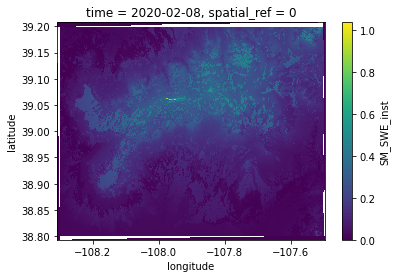

In [8]:
out_reproj['SM_SWE_inst'].plot()

In [9]:
out_reproj.to_netcdf('LIS_modelOutput_GMClip_2020-02-08.nc')